# **State Reducers**

LangGraph state reducers help in managing how state is updated across the graph. This is especially useful when multiple nodes need to update the same key or "channel" in the state. By default, if two nodes attempt to update the same key, they overwrite each other. Reducers give us control over how those state updates should behave (e.g., combining values rather than overwriting).

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## **Default Overwriting State:**

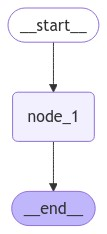

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define State
class State(TypedDict):
    foo: int

# This block defines the state schema using Python's TypedDict.
# State has one key: foo, which is an integer (int). This state will be passed across the graph.

# Nodes
def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# node_1 takes the current state and increments the foo value by 1.
# The return value is a dictionary where foo is updated.

# Build graph
builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : 1})

# We invoke the graph by passing the initial state where foo = 1.
# The result will increment foo by 1 (1 + 1 = 2).

---Node 1---


{'foo': 2}

## **Branching:**

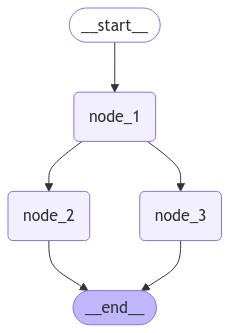

In [3]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Define State
class State(TypedDict):
    foo: int

# Nodes
def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# The graph starts at node_1 and branches into two possible nodes: node_2 and node_3.
# Both node_2 and node_3 attempt to modify the state in parallel.
# They both attempt to overwrite the state within the same step.
# This is ambiguous for the graph! Which state should it keep?

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
# Invoke
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## **Reducers:**

Reducers specify how state updates should be handled when there is potential ambiguity. We can use the Annotated type to specify a reducer function.

For example, in this case let's append the value returned from each node rather than overwriting them.

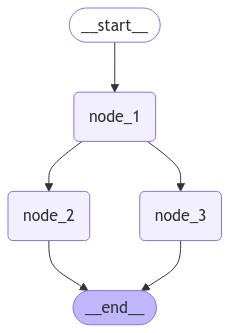

In [13]:
from typing_extensions import TypedDict
from operator import add
from typing import Annotated
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# State
class State(TypedDict):
    foo: Annotated[list[int], add]

# Reducer (add):
# The foo key is annotated with add, which is a reducer from Python’s operator module.
# This reducer specifies how updates to the foo list should be handled.
# Specifically, add will concatenate or append new values to the existing list instead of overwriting it.

# Nodes
# initial state= [1]
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}  #[1+1] returns=[2]
# state_update= [1] + [2] = [1, 2]

def node_2(state):
    print("---Node 2---")                   #[1, 2]
    return {"foo": [state['foo'][-1] + 1]}  #[2+1] return= [3]
# state_update= [1, 2] + [3] = [1, 2, 3]

def node_3(state):
    print("---Node 3---")                   #[1, 2]
    return {"foo": [state['foo'][-1] + 1]}  #[2+1] return= [3]
# state_update= [1, 2] + [3] = [1, 2, 3]

# input: The current state is passed into the node as an argument (state).
# State Access: Each node accesses the last element of the foo list (state['foo'][-1]) and adds 1 to it.
# Return: The nodes return a dictionary with the updated foo key, wrapping the result in a list: {"foo": [state['foo'][-1] + 1]}.
# Conclusion: We are telling the nodes here is a list, take the last element and add "1" in it and whatever result you have cooked up and Add reducer adds it at the end of the provided list
# Since node 2 and node 3 were performed at the same step, both of their returned values will be appened in our state list
# Hence our list becomes [1, 2, 3, 3]

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

### **Passing None to the State:**

In [11]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


**Invalid Operation:** None is not a valid operand for list concatenation. The operator.add reducer expects two lists to concatenate. However, when it encounters None, it fails because it doesn't know how to combine None with a list.

The node_1 function (or any other node) would attempt to concatenate None with a list using the add reducer. This leads to a TypeError because Python does not know how to combine None and a list.

## **Custom Reducers:**

If we need to handle more complex cases, such as when the input is None, we can define a custom reducer.

 lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be None

In [2]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []  # If left is None, make it an empty list
    if not right:
        right = []  # If right is None, make it an empty list
    return left + right

**Example Usage:**
```
print(reduce_list([1, 2], [3, 4]))  # Output: [1, 2, 3, 4]
print(reduce_list(None, [3, 4]))    # Output: [3, 4]
print(reduce_list([1, 2], None))    # Output: [1, 2]
print(reduce_list(None, None))      # Output: []
```



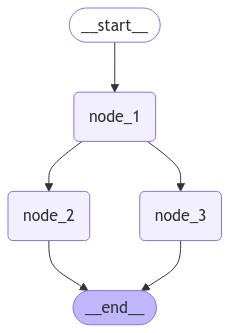

In [28]:
from typing_extensions import TypedDict
from operator import add
from typing import Annotated
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

# Nodes
def node_1(state):
    print("---Node 1---")
    # Initialize the list with a default value if it's empty
    if not state['foo']:
        return {"foo": [1]}  # Starting value if foo is empty
    return {"foo": [state['foo'][-1] + 1]}  # Increment last element

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
graph.invoke({"foo" : None})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 2]}